In [2]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path

dataset_path = Path("datasets/kaist-rgbt/train")
label = "set03_V001_I00287"
# label = "set04_V001_I02771"

labels = [
    "set04_V001_I01275",
    "set04_V001_I01279",
    "set04_V001_I01283",
    "set04_V001_I01287",
    "set04_V001_I01291",
    "set03_V001_I00179",
    "set03_V001_I00175",
    "set03_V001_I00183",
    "set03_V001_I00171",
]

category_dict = {
    'person': 0,
    'cyclist': 1,
    'people': 2,
    'person?': 3,
}

def visualize_bbox_label():
    # 파일 경로 설정
    image_path = dataset_path / "images" / "visible" / f"{label}.jpg"
    xml_path = dataset_path / "labels-xml" / f"{label}.xml"

    # 이미지 읽기
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # XML 파싱
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Bounding box 그리기
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        x = int(bbox.find('x').text)
        y = int(bbox.find('y').text)
        w = int(bbox.find('w').text)
        h = int(bbox.find('h').text)
        color = (255, 255, 255) if name == 'person' else (0, 0, 255)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
        cv2.putText(image, str(category_dict[name]), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # BGR -> RGB 변환 후 시각화
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Bounding Boxes')
    plt.axis('off')

    # 원본 이미지 다시 읽기
    orig_image = cv2.imread(str(image_path))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

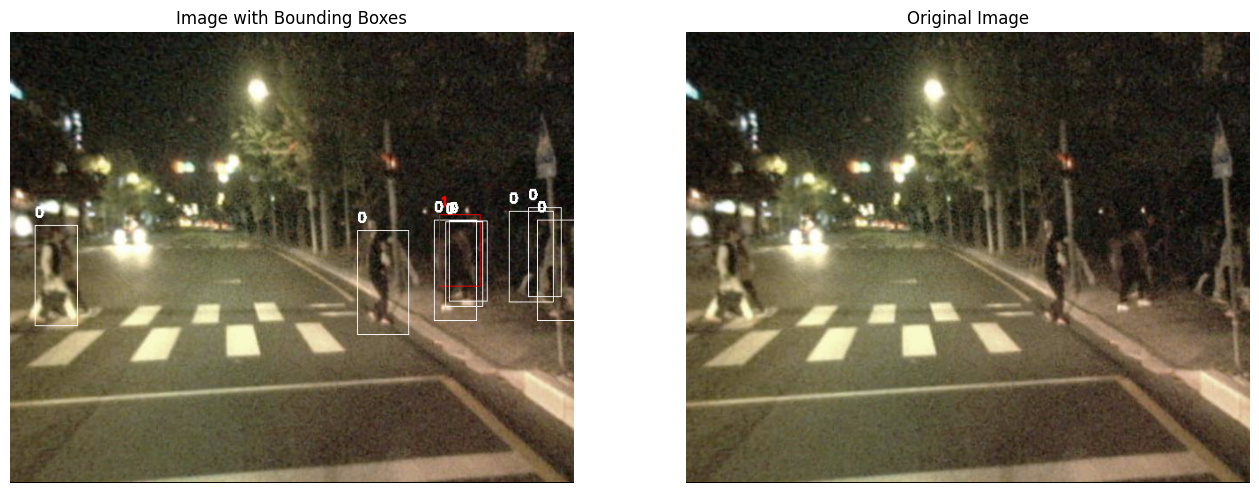

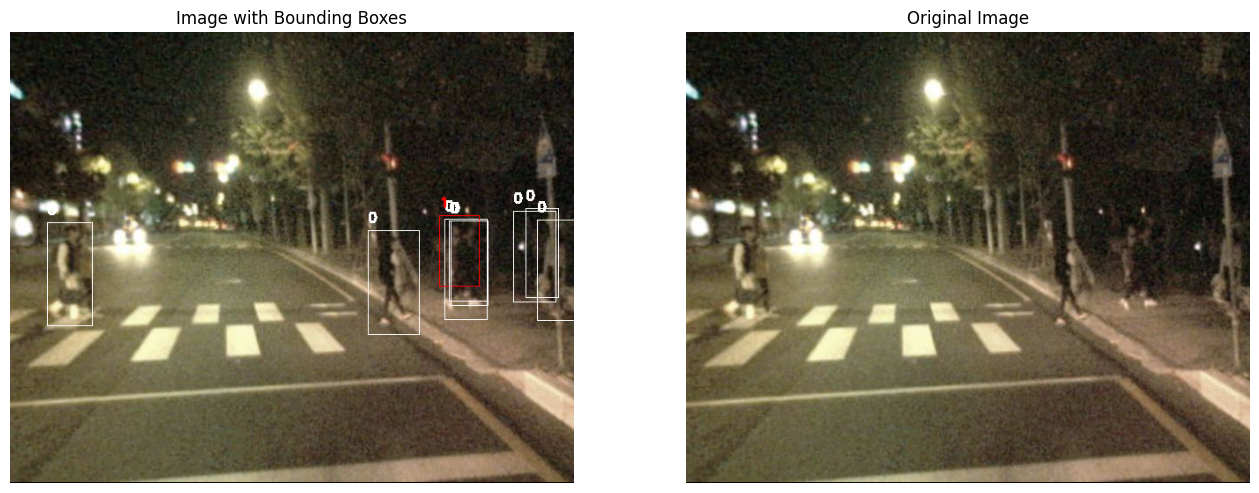

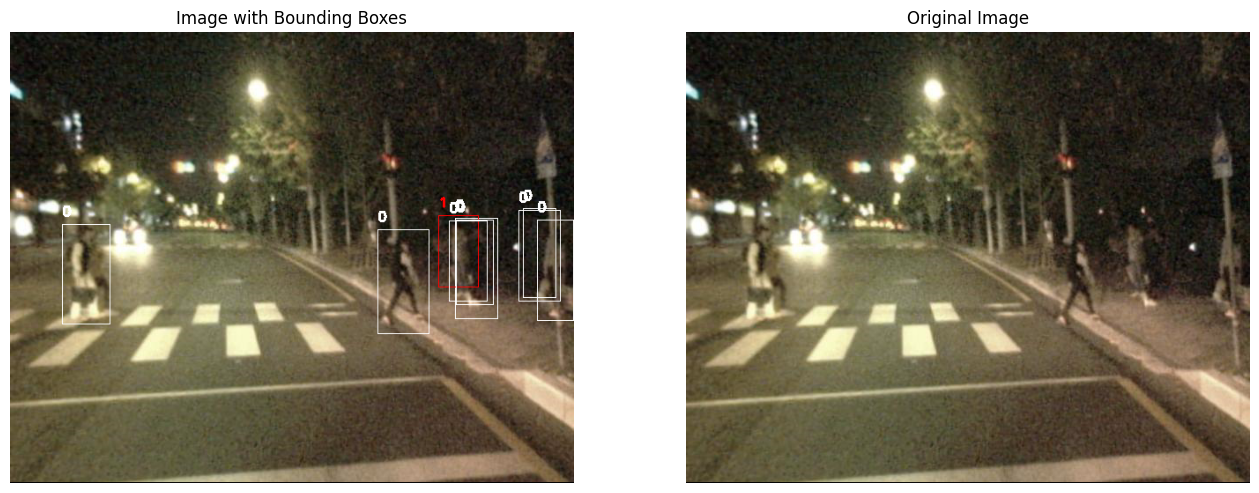

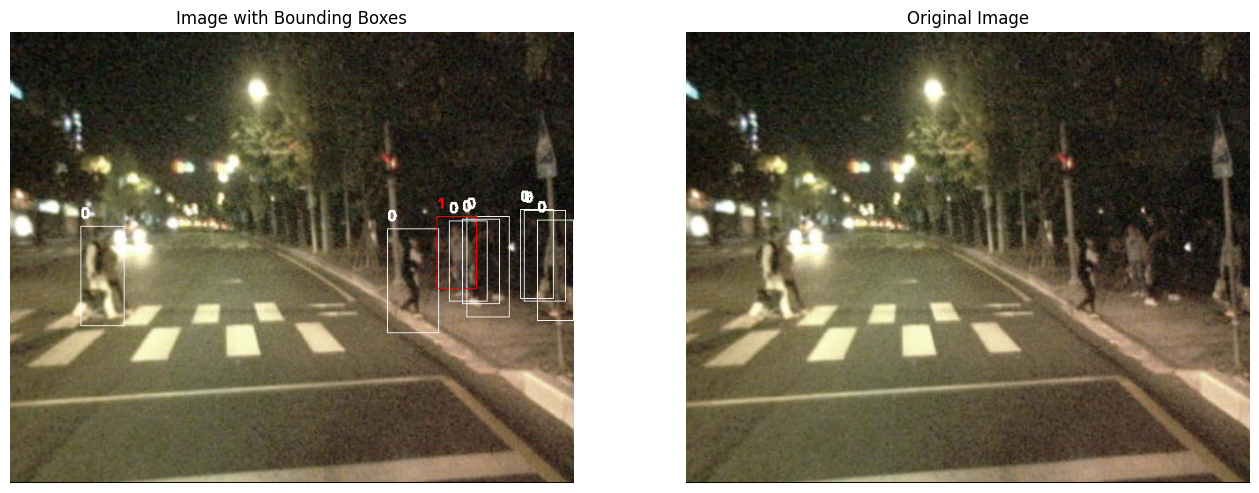

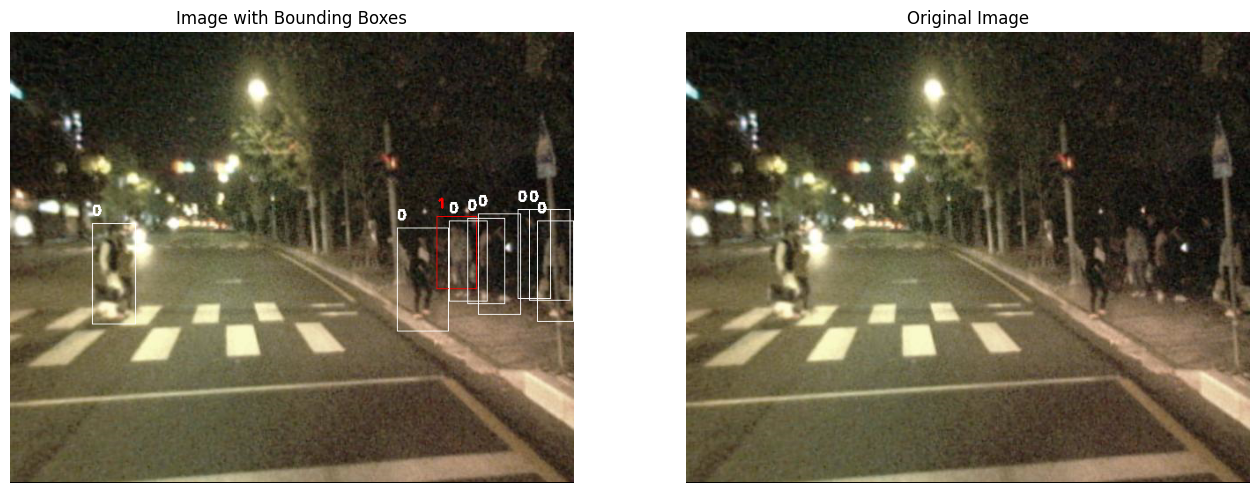

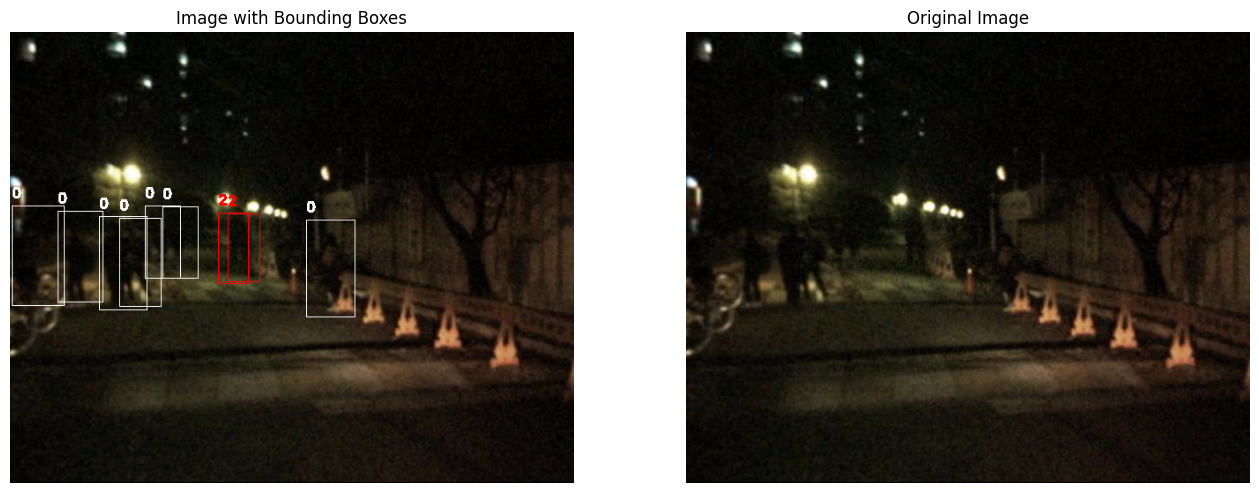

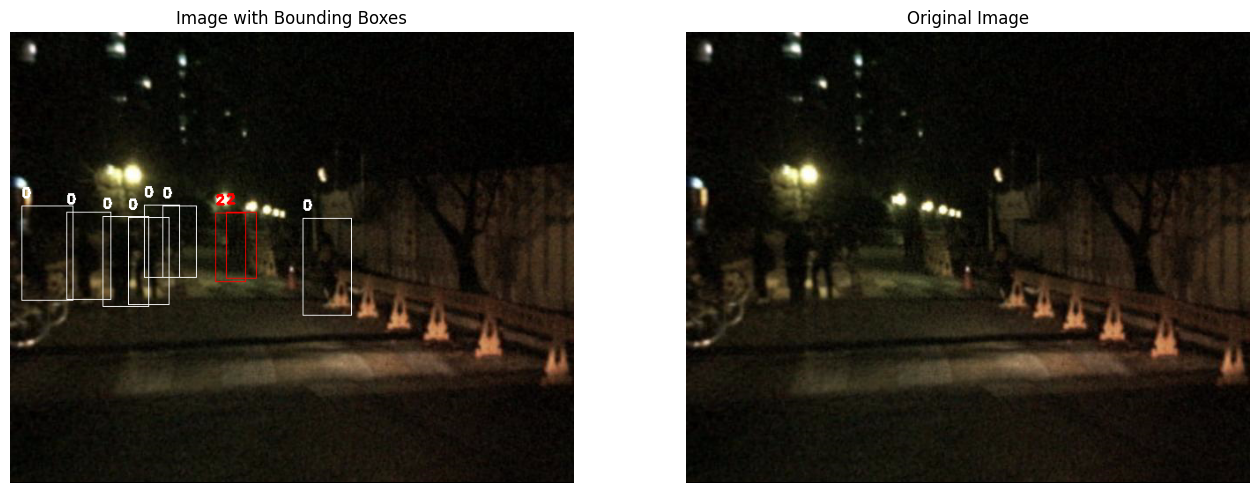

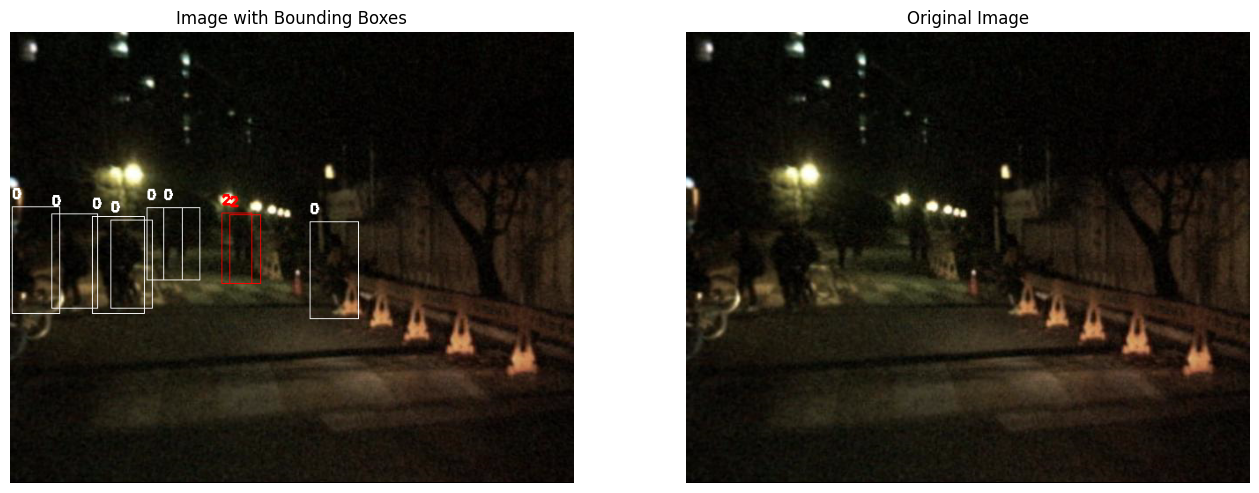

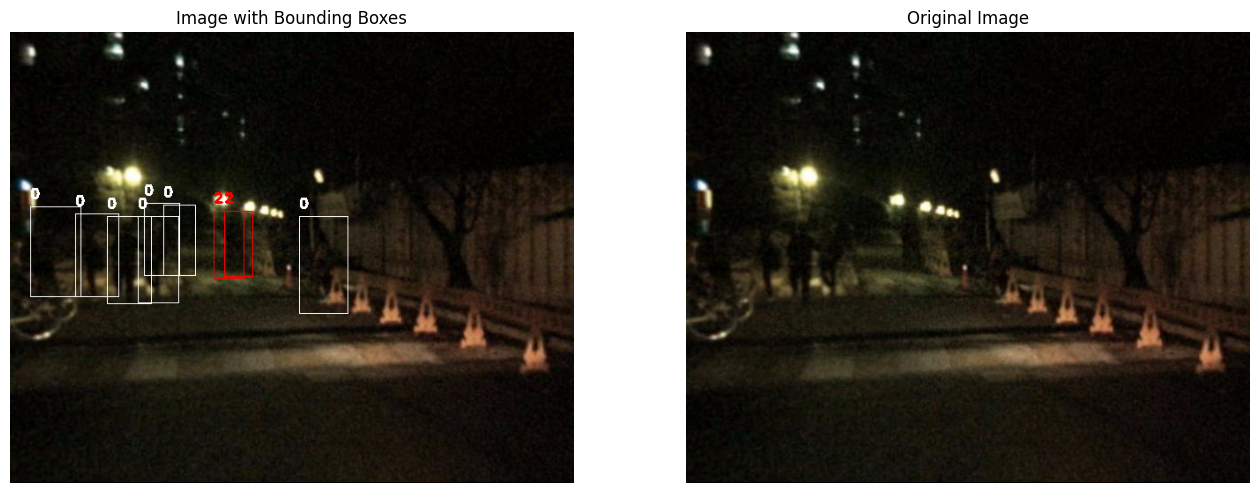

In [24]:
for label in labels:
    visualize_bbox_label()

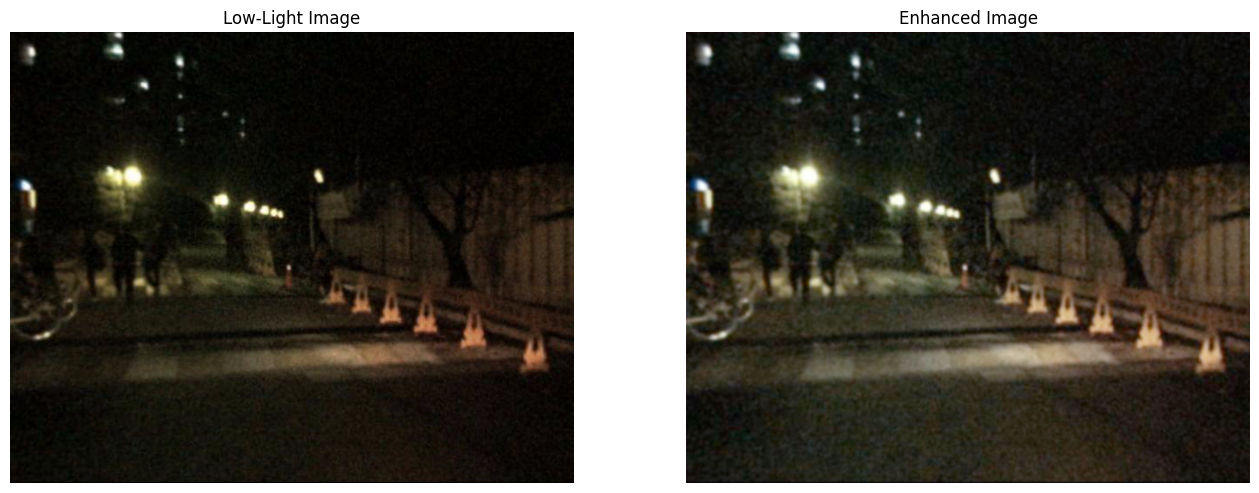

In [9]:
import torch

import os
from pathlib import Path
from tqdm import tqdm
import sys
CLODE_PATH = Path("/home/soom/CLODE")
sys.path.append(str(CLODE_PATH))

from misc import *
from network.conv_node import NODE

os.environ["CUDA_VISIBLE_DEVICES"] = '4'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_PATH = CLODE_PATH / "pth" / "lowlight.pth"
IMAGE_PATH = dataset_path / "images" / "visible" / f"set03_V001_I00171.jpg"

model = NODE(device, (3, 128, 128), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True), strict=False)

T = torch.tensor([0, 1]).float().to(device)

with torch.no_grad():
    lq = image_tensor(IMAGE_PATH).unsqueeze(0).to(device)
    pred = model(lq, T, inference=True)['output']  
    hq = pred[0].cpu().numpy()

# subfigures
plt.figure(figsize=(16, 8))
# lq 이미지 변환
lq = lq.squeeze(0).cpu().numpy().transpose(1, 2, 0)
lq = (lq * 255).clip(0, 255).astype('uint8')
plt.subplot(1, 2, 1)
plt.imshow(lq)
plt.title('Low-Light Image')
plt.axis('off')
# hq 이미지 변환
hq = (hq * 255).clip(0, 255).astype('uint8')
plt.subplot(1, 2, 2)
plt.imshow(hq.transpose(1, 2, 0))
plt.title('Enhanced Image')
plt.axis('off')
plt.show()